Выполнила: Блинова Елена М., КЭ-128

Вариант: 2 (алгоритм логистической регрессии)



# Анализ сетевого трафика методом логистической регрессии
Данная работа включает следующие основные разделы:
- описание набора данных
- импорт используемых библиотек
- предварительная обработка данных
- реализация алгоритма логистической регрессии
- обучение модели
- документация

## Описание набора данных


Исходный набор данных: CIC UNSW-NB15 Augmented Dataset (https://www.unb.ca/cic/datasets/cic-unsw-nb15.html)


Данный набор даннх предназначен для обнаружения сетевых вторжений NIDS. Он включает в себя нормальный сетевой трафик и 9 типов атак:

В наборе данных представлены 76 признаков, которые описывают различные аспекты сетевого трафика.

Файл Data.csv содержит признаки сетевого трафика.

Файл Label.csv содержит метки для каждого наблюдения в Data.csv, которые указывают на то, является ли данный трафик нормальным или аномальным.

Файл Readme.txt содержит список меток классов для различных типов трафика и атак:
- Benign (0): Нормальный трафик.
- Analysis (1): Атаки, связанные с анализом.
- Backdoor (2): Атаки через "backdoor" - скрытый доступ.
- DoS (3): Атаки типа отказа в обслуживании (Denial of Service).
- Exploits (4): Использование уязвимостей.
- Fuzzers (5): Атаки с использованием fuzzing.
- Generic (6): Общие атаки.
- Reconnaissance (7): Разведывательные атаки.
- Shellcode (8): Атаки с использованием shell-кодов.
- Worms (9): Черви.

Целью анализа является классификация сетевого трафика как "нормальный" или "аномальны" (атакующий).

## Импорт используемых библиотек
Подключение Google Диска к Colab

In [ ]:
#!pip install mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Модуль для взаимодействия с файловой системой
import os
# Библиотека для работы с данными, предоставляющая удобные структуры данных и методы для анализа и манипулирования данными
import pandas as pd
# Библиотека для визуализации данных на основе matplotlib, предоставляет интерфейс для создания графиков
import seaborn as sns
# Основной модуль для создания графиков и визуализаций в Python
import matplotlib.pyplot as plt
# Библиотека для работы с многомерными массивами и матрицами, а также математических функций для работы с ними
import numpy as np
# Функция для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
# Класс для нормализации данных, приводящий признаки к диапазону [0, 1]
from sklearn.preprocessing import MinMaxScaler
# Функция для вычисления точности предсказаний модели
from sklearn.metrics import accuracy_score
# Функция для минимизации (оптимизации) заданной целевой функции, используется для нахождения оптимальных параметров модели
from scipy.optimize import minimize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Предварительная обработка данных
- загрузка и визуализация данных
- вычисление корреляции и выбор признаков для построения модели
- преобразование данных (нормализация)
- разделение данных (разбивка датасета на тренировочный и тестовый наборы)

### Загрузка данных

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Dataset/CIC UNSW-NB15')

# Загрузка данных
data = pd.read_csv('Data.csv')
labels = pd.read_csv('Label.csv')

### Просмотр первых строк файлов

In [ ]:
data.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,214392,9,21,388.0,24564.0,194.0,0.0,43.111111,85.545959,1460.0,...,2,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2376792,9,3,752.0,0.0,188.0,0.0,83.555556,99.084700,0.0,...,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,131350,10,3,7564.0,0.0,1460.0,0.0,756.400000,690.497277,0.0,...,6,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,164796,6,3,770.0,0.0,385.0,0.0,128.333333,198.813145,0.0,...,2,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,163418,6,3,400.0,0.0,200.0,0.0,66.666667,103.279556,0.0,...,2,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels.head()

,Label
0,4
1,7
2,4
3,3
4,6


In [ ]:
readme_file = os.path.join('readme.txt')

# Открытие файла readme.txt для чтения
with open(readme_file, 'r') as file:
    readme_content = file.readlines()

# Инициализация пустого словаря для хранения маппинга меток
label_mapping = {}
for line in readme_content:
    # Удаление начальных и конечных пробелов и разделение строки на части
    parts = line.strip().split()
    # Проверка, что строка состоит из двух частей (метка и код)
    if len(parts) == 2:
        label, code = parts
        # Добавление метки и кода в словарь, преобразуя код в целое число
        label_mapping[label] = int(code)

print(label_mapping)

{'Benign': 0, 'Analysis': 1, 'Backdoor': 2, 'DoS': 3, 'Exploits': 4, 'Fuzzers': 5, 'Generic': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


### Получение информации о DataFrame, включая количество ненулевых значений и типы данных каждого столбца

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447915 entries, 0 to 447914
Data columns (total 76 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow Duration               447915 non-null  int64  
 1   Total Fwd Packet            447915 non-null  int64  
 2   Total Bwd packets           447915 non-null  int64  
 3   Total Length of Fwd Packet  447915 non-null  float64
 4   Total Length of Bwd Packet  447915 non-null  float64
 5   Fwd Packet Length Max       447915 non-null  float64
 6   Fwd Packet Length Min       447915 non-null  float64
 7   Fwd Packet Length Mean      447915 non-null  float64
 8   Fwd Packet Length Std       447915 non-null  float64
 9   Bwd Packet Length Max       447915 non-null  float64
 10  Bwd Packet Length Min       447915 non-null  float64
 11  Bwd Packet Length Mean      447915 non-null  float64
 12  Bwd Packet Length Std       447915 non-null  float64
 13  Flow Bytes/s  

- Общее количество записей: 447915
- Количество столбцов (признаков): 76
- Количество пропущенных значений: 0

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447915 entries, 0 to 447914
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Label   447915 non-null  int64
dtypes: int64(1)
memory usage: 3.4 MB


- Количество записей: 447915
- Количество столбцов: 1
- Количество пропущенных значений: 0

### Вывод основных статистических характеристик числовых данных

In [ ]:
data.describe()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,4.479150e+05,447915.000000,447915.000000,4.479150e+05,4.479150e+05,447915.000000,447915.000000,447915.000000,447915.000000,447915.000000,...,447915.000000,447915.000000,4.479150e+05,4.479150e+05,4.479150e+05,4.479150e+05,4.479150e+05,4.479150e+05,4.479150e+05,4.479150e+05
mean,5.983003e+05,22.598428,27.238503,4.778406e+03,2.170251e+04,174.243153,14.918360,71.264324,64.000867,365.009993,...,8.628521,25.926651,1.868487e+04,9.409518e+03,3.126578e+04,1.252120e+04,9.859284e+04,3.341817e+03,1.026228e+05,9.578854e+04
std,4.878777e+06,127.986936,116.638803,1.518561e+05,1.477431e+05,352.171446,71.570572,184.565303,156.387353,555.808533,...,118.663262,9.017636,7.487275e+05,5.231382e+05,1.174788e+06,6.397847e+05,2.222806e+06,2.201782e+05,2.260988e+06,2.207332e+06
min,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.490000e+02,1.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.788000e+03,3.000000,2.000000,9.000000e+01,1.060000e+02,45.000000,0.000000,9.346154,0.000000,48.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.792405e+05,17.000000,15.000000,4.860000e+02,1.512000e+03,163.000000,0.000000,50.000000,29.277002,731.000000,...,10.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.199975e+08,20038.000000,11021.000000,2.605270e+07,1.421599e+07,1476.000000,1472.000000,1474.000000,848.528137,1460.000000,...,20032.000000,40.000000,1.104063e+08,7.417760e+07,1.104063e+08,1.104063e+08,1.191926e+08,7.214360e+07,1.191926e+08,1.191926e+08


Высокие значения стандартного отклонения (std).

Признаки с высоким стандартным отклонением демонстрируют значительное различие между значениями.

In [ ]:
data['Label'] = labels['Label'].values
data.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,214392,9,21,388.0,24564.0,194.0,0.0,43.111111,85.545959,1460.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,2376792,9,3,752.0,0.0,188.0,0.0,83.555556,99.084700,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,131350,10,3,7564.0,0.0,1460.0,0.0,756.400000,690.497277,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,164796,6,3,770.0,0.0,385.0,0.0,128.333333,198.813145,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,163418,6,3,400.0,0.0,200.0,0.0,66.666667,103.279556,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


### Вычисление корреляции и важности признаков

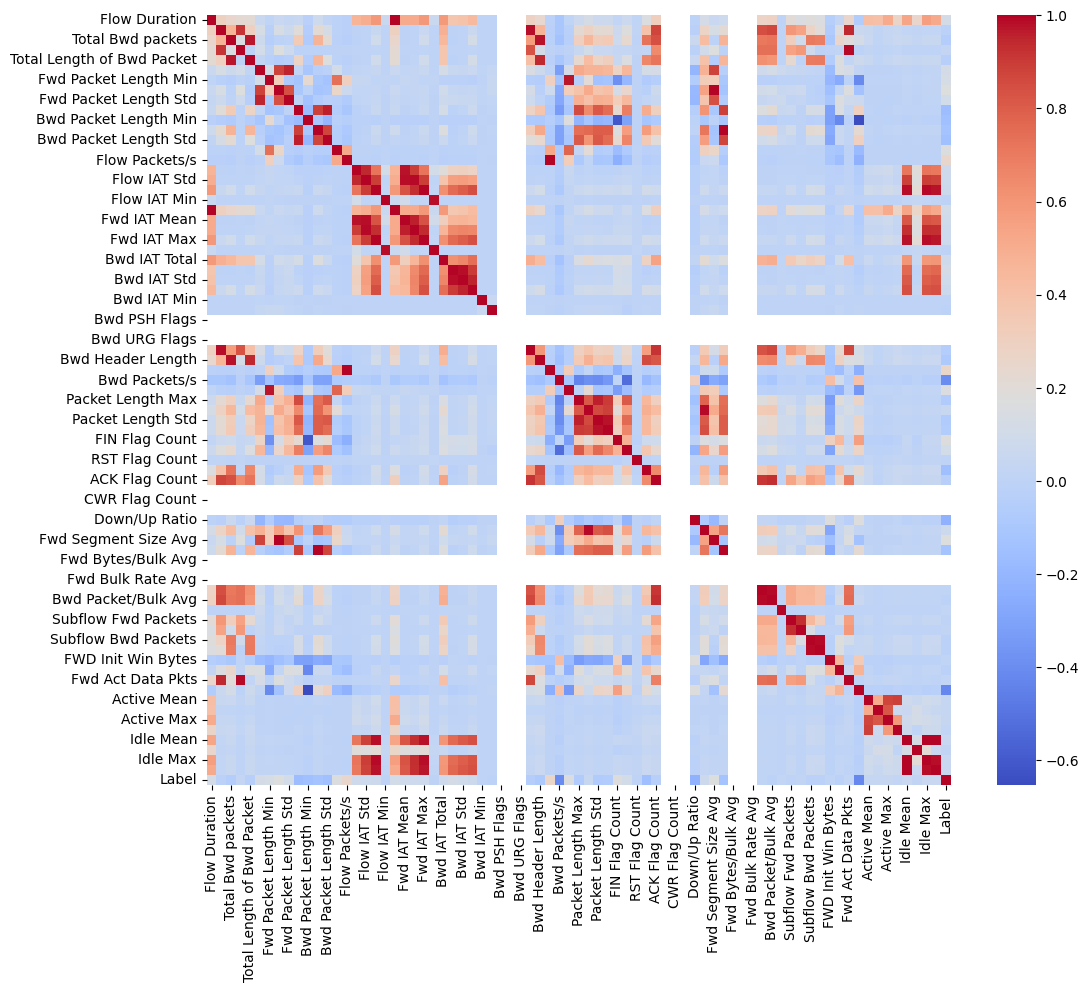

In [ ]:
# Подсчет корреляции
correlation_matrix = data.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

In [ ]:
# Получение корреляций всех признаков с целевой переменной
target_correlation = correlation_matrix['Label'].abs().sort_values(ascending=False)
# Вывод признаков с наибольшей корреляцией с целевой переменной
target_correlation.head(10)

,Label
Label,1.000000
Fwd Seg Size Min,0.425235
Bwd Packets/s,0.401995
Fwd Packets/s,0.260112
Flow Packets/s,0.246948
Down/Up Ratio,0.230342
FIN Flag Count,0.173565
Fwd Segment Size Avg,0.167024
Fwd Packet Length Mean,0.167024
Flow Bytes/s,0.165808


In [ ]:
# Создание нового датафрейма с выбранными признаками и меткой
selected_features = [
    'Label',
    'Fwd Seg Size Min',
    'Bwd Packets/s',
    'Fwd Packets/s',
    'Flow Packets/s',
    'Down/Up Ratio'
]
selected_data = data[selected_features]
selected_data.head()

,Label,Fwd Seg Size Min,Bwd Packets/s,Fwd Packets/s,Flow Packets/s,Down/Up Ratio
0,4,20,97.951416,41.979178,139.930594,2.0
1,7,20,1.262206,3.786617,5.048822,0.0
2,4,20,22.839741,76.132470,98.972212,0.0
3,3,20,18.204325,36.408651,54.612976,0.0
4,6,20,18.357831,36.715662,55.073493,0.0


In [ ]:
# Создание бинарной метки
selected_data['Binary_Label'] = selected_data['Label'].apply(lambda x: 1 if x > 0 else 0)

X = selected_data[selected_features[1:]].values  # Все признаки, кроме 'Label'
y = selected_data['Binary_Label'].values  # Бинарная метка


<ipython-input-14-611fa3884eae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Binary_Label'] = selected_data['Label'].apply(lambda x: 1 if x > 0 else 0)


### Визуализация данных


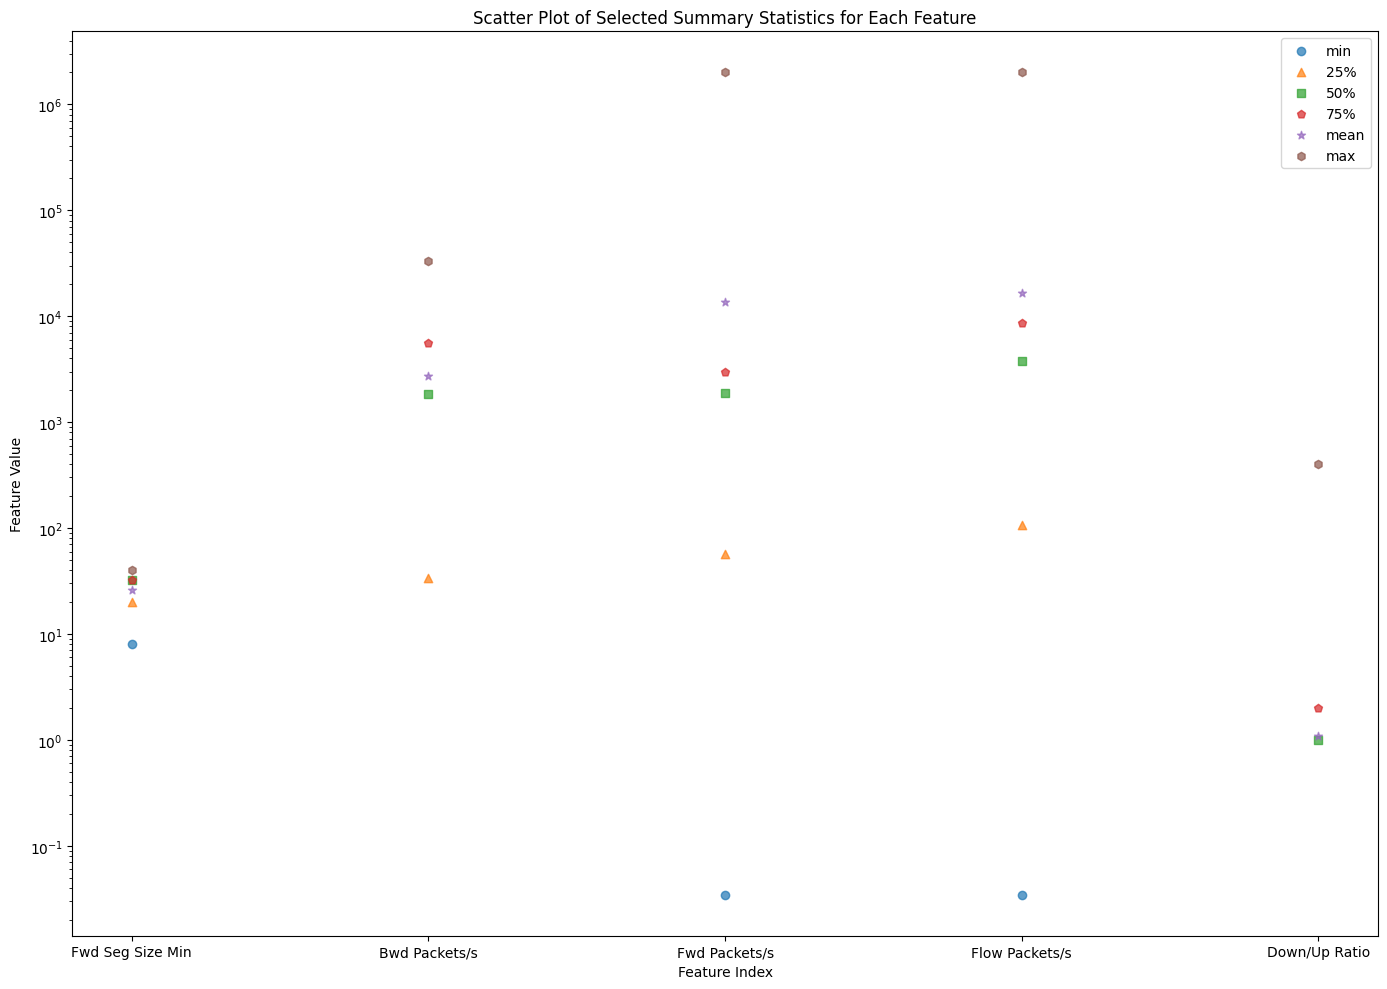

In [ ]:


# Символы для различных статистик сводки (обозначение точек на графике)
markers = ['o', '^', 's', 'p', '*', 'h']

# Расчёт статистик сводки для каждого признака
summary_stats = {
    'min': X.min(axis=0), # Минимальное значение для каждого признака
    '25%': np.percentile(X, 25, axis=0), #25-й перцентиль для каждого признака
    '50%': np.percentile(X, 50, axis=0), # Медиана (50-й перцентиль) для каждого признака
    '75%': np.percentile(X, 75, axis=0), # 75-й перцентиль для каждого признака
    'mean': X.mean(axis=0), # Среднее значение для каждого признака
    'max': X.max(axis=0) # Максимальное значение для каждого признака
}

# Создание диаграммы рассеяния для статистик сводки
plt.figure(figsize=(14, 10))

# Построение точек для каждой статистики сводки
for idx, (stat, marker) in enumerate(zip(summary_stats.keys(), markers)):
    plt.scatter(np.arange(len(selected_features[1:])), summary_stats[stat], marker=marker, alpha=0.7, label=stat)

# Добавление подписей и заголовка
plt.legend(loc='best') # Легенда наилучшего расположения
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.yscale('log') # Логарифмическая шкала для оси Y
plt.title('Scatter Plot of Selected Summary Statistics for Each Feature')
plt.xticks(np.arange(len(selected_features[1:])), selected_features[1:]) # Метки на оси X с поворотом на 45 градусов
plt.tight_layout()
plt.show() # Отображение графика


In [ ]:


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка размерностей выборок
print(f"Размер обучающей выборки: {X_train.shape[0]} записей")
print(f"Размер тестовой выборки: {X_test.shape[0]} записей")


Размер обучающей выборки: 358332 записей
Размер тестовой выборки: 89583 записей


### Нормализация данных

In [ ]:


# Нормализация данных на обучающей выборке
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

# Применение нормализации к тестовой выборке
X_test_normalized = scaler.transform(X_test)

# Преобразование нормализованных данных обратно в DataFrame
X_train_normalized = pd.DataFrame(X_train_normalized, columns=selected_features[1:])#  columns=selected_features[1:]
X_test_normalized = pd.DataFrame(X_test_normalized, columns=selected_features[1:])#


In [ ]:
X_train_normalized.head()

,Fwd Seg Size Min,Bwd Packets/s,Fwd Packets/s,Flow Packets/s,Down/Up Ratio
0,0.000000,0.017422,0.000290,0.000581,0.0025
1,0.857143,0.185185,0.001543,0.004630,0.0050
2,0.857143,0.173913,0.001449,0.004348,0.0050
3,0.000000,0.057526,0.000959,0.001918,0.0025
4,0.857143,0.174419,0.001453,0.004360,0.0050


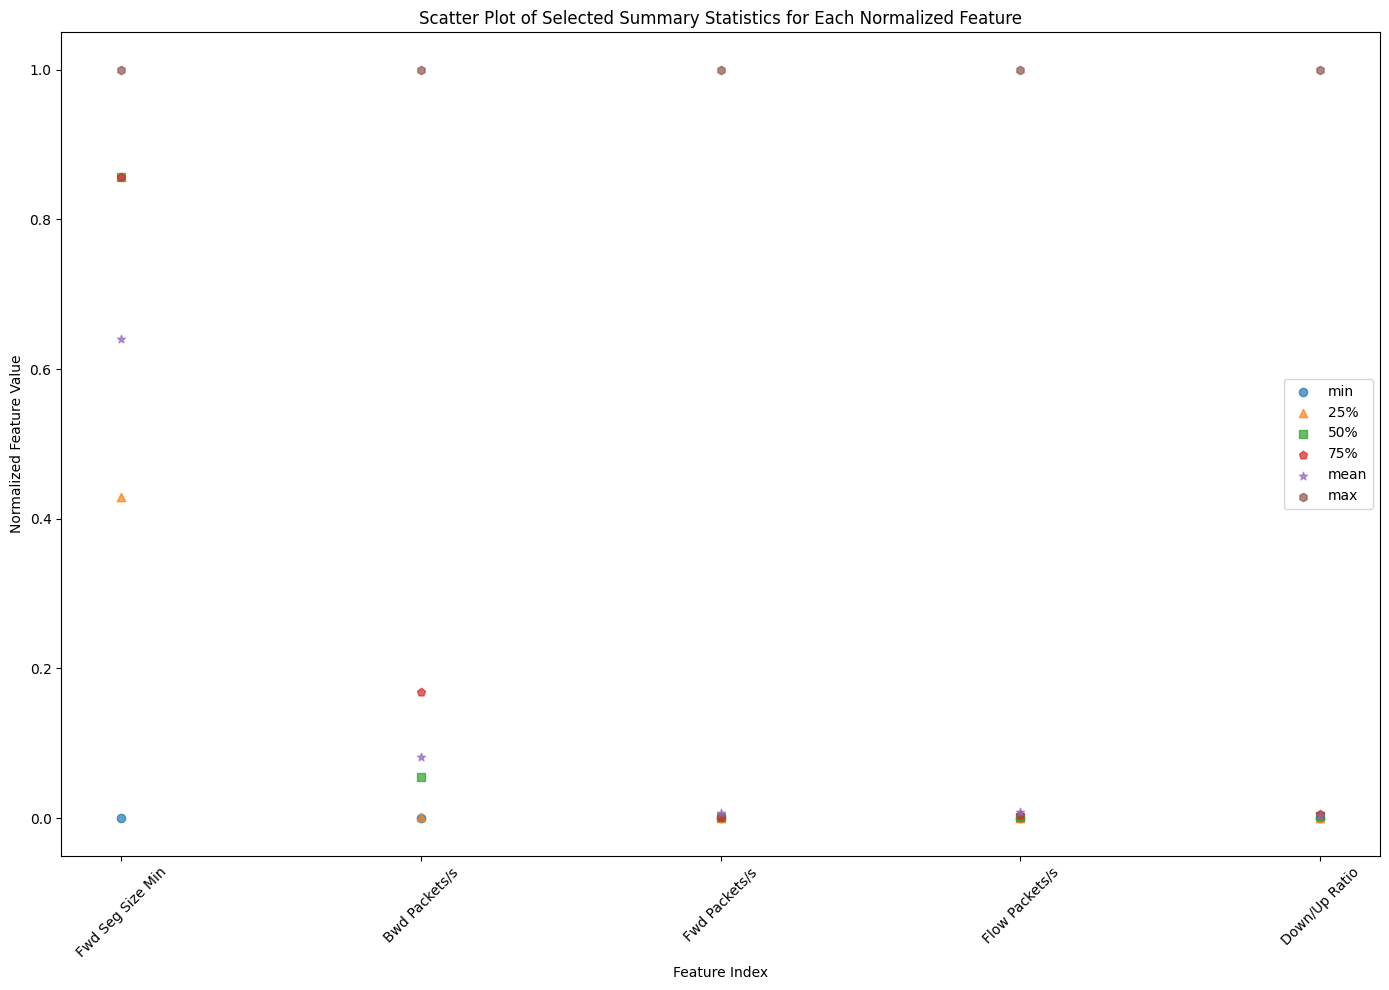

In [ ]:
# Расчёт статистик сводки для каждого нормализованного признака
summary_stats_normalized = {
    'min': X_train_normalized.min(axis=0),
    '25%': np.percentile(X_train_normalized, 25, axis=0),
    '50%': np.percentile(X_train_normalized, 50, axis=0),
    '75%': np.percentile(X_train_normalized, 75, axis=0),
    'mean': X_train_normalized.mean(axis=0),
    'max': X_train_normalized.max(axis=0)
}

# Создание диаграммы рассеяния для статистик сводки нормализованных анных
plt.figure(figsize=(14, 10))

for idx, (stat, marker) in enumerate(zip(summary_stats_normalized.keys(), markers)):
    plt.scatter(np.arange(len(selected_features[1:])), summary_stats_normalized[stat], marker=marker, alpha=0.7, label=stat)

# Добавление подписей и заголовка
plt.legend(loc='best')
plt.xlabel('Feature Index')
plt.ylabel('Normalized Feature Value')
plt.title('Scatter Plot of Selected Summary Statistics for Each Normalized Feature')
plt.xticks(np.arange(len(selected_features[1:])), selected_features[1:], rotation=45)
plt.tight_layout()
plt.show()


## Реализация алгоритма логистической регрессии

Функция сигмоиды:
- для определения вероятности приналлежности к одному из двух классов

In [ ]:
# Функция сигмоиды
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Функция стоимости с регуляризацией:
- Цель: оценить, насколько хорошо текущие параметры модели (theta) предсказывают целевую переменную (y) на основании входных данных (X)
- Влияние: помогает предотвратить переобучение, добавляя штраф за большие значения параметров. Параметр регуляризации (lam) регулирует степень этого штрафа

In [ ]:
# Функция стоимости с регуляризацией
def costFunctionR(theta, X, y, lam):
    m = len(y)
    # Вычисление предсказанных значений с использованием сигмоидной функции
    h = sigmoid(np.dot(X, theta))
    # Малое значение для предотвращения логарифмического переполнения
    epsilon = 1e-5
    # формула стоимости с регуляризацией
    J = (-1/m) * (np.dot(y, np.log(h + epsilon)) + np.dot((1 - y), np.log(1 - h + epsilon))) + (lam / (2 * m)) * np.sum(np.square(theta[1:]))
    return J

Функция градиента с регуляризацией:
- Цель: вычислить градиент функции стоимости для определения направления, в котором будет меняться параметр (theta) для минимизации функции стоимости.
- Влияние: вычисленные градиенты используются для обновления параметров модели на каждом шаге оптимизации

In [ ]:
# Функция градиента с регуляризацией
def gradientFuncR(theta, X, y, lam):
    m = len(y)
    # Вычисление предсказанных значений с использованием сигмоидной функции
    h = sigmoid(np.dot(X, theta))
    # Вычисление градиента функции стоимости без регуляризации
    gradient = (1/m) * np.dot(X.T, (h - y))
    # Добавление регуляризационного члена к градиенту (начиная с первого элемента)
    gradient[1:] += (lam / m) * theta[1:]
    return gradient

Функция тренировки логистической регресси:
- Цель: обучить модель логистической регрессии, минимизируя функцию стоимости с помощью оптимизации параметров.
- Влияние: метод minimize из модуля scipy.optimize использует реализованные функцию стоииости и градиента для нахождения оптимальных параметров.

In [ ]:


# Функция для тренировки логистической регрессии
def trainLogisticRegression(X, y, lam, method):
    # Инициализация параметров
    initial_theta = np.zeros(X.shape[1])
    # Параметры оптимизации:
    # Целевая функция, которую нужно минимизировать
    # Начальное приближение решения
    # аргументы, передаваемые в целевую функцию
    # Метод оптимизации
    # Функция градиента
    result = minimize(costFunctionR, initial_theta, args=(X, y, lam), method=method, jac=gradientFuncR)

    return result.x

In [ ]:


# Функция для предсказания
def predict(X, theta):
    return sigmoid(np.dot(X, theta)) >= 0.5

## Обучение модели

In [ ]:
# Добавление столбца единиц для интерсепта
X_train_normalized = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test_normalized = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

In [ ]:
# Создание списка для хранения результатов для каждой комбинации λ и метода оптимизации
results = []

# Настройка параметра регуляризации и оценка точности модели
lambda_values = [0.01, 0.1, 1, 10]
methods = ['TNC', 'CG']

# Проход по каждому методу оптимизации
for method in methods:
    print(f'Тестируем метод: {method}')
    for lambda_param in lambda_values:
        # Обучение модели и получение оптимального theta для заданного λ и метода оптимизации
        theta_optimal = trainLogisticRegression(X_train_normalized, y_train, lambda_param, method)

        # Предсказание значений для тренировочного и тестового наборов данных
        y_train_pred = predict(X_train_normalized, theta_optimal)
        y_test_pred = predict(X_test_normalized, theta_optimal)

        # Расчет точности
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Сохранение λ, метода, theta и точностей в список результатов
        results.append({
            'lambda': lambda_param,
            'method': method,
            'theta': theta_optimal,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        })

        # Вывод результатов для каждого значения λ и метода оптимизации
        print(f'Метод оптимизации: {method}')
        print(f'Параметр регуляризации (lambda): {lambda_param}')
        print(f'Точность на тренировочном наборе данных: {train_accuracy * 100:.2f}%')
        print(f'Точность на тестовом наборе данных: {test_accuracy * 100:.2f}%\n')


Тестируем метод: TNC
Метод оптимизации: TNC
Параметр регуляризации (lambda): 0.01
Точность на тренировочном наборе данных: 95.81%
Точность на тестовом наборе данных: 95.84%

Метод оптимизации: TNC
Параметр регуляризации (lambda): 0.1
Точность на тренировочном наборе данных: 96.29%
Точность на тестовом наборе данных: 96.30%

Метод оптимизации: TNC
Параметр регуляризации (lambda): 1
Точность на тренировочном наборе данных: 96.20%
Точность на тестовом наборе данных: 96.19%

Метод оптимизации: TNC
Параметр регуляризации (lambda): 10
Точность на тренировочном наборе данных: 96.29%
Точность на тестовом наборе данных: 96.27%

Тестируем метод: CG
Метод оптимизации: CG
Параметр регуляризации (lambda): 0.01
Точность на тренировочном наборе данных: 82.45%
Точность на тестовом наборе данных: 82.49%

Метод оптимизации: CG
Параметр регуляризации (lambda): 0.1
Точность на тренировочном наборе данных: 82.45%
Точность на тестовом наборе данных: 82.49%

Метод оптимизации: CG
Параметр регуляризации (lamb

### Выбор оптимальных параметров модели

In [ ]:
selected_lambda = 0.1
for result in results:
    if result['lambda'] == selected_lambda:
        print(f"\nОптимальные параметры для lambda = {selected_lambda}:")
        print(f"Тета: {result['theta']}")
        print(f"Точность на тренировочном наборе: {result['train_accuracy'] * 100:.2f}%")
        print(f"Точность на тестовом наборе: {result['test_accuracy'] * 100:.2f}%")
        break


Оптимальные параметры для lambda = 0.1:
Тета: [ 6.32045205e+00 -2.37585878e-01  5.89172207e-03  1.98538132e-02
 -1.98556261e-02 -2.85192801e-02]
Точность на тренировочном наборе: 96.29%
Точность на тестовом наборе: 96.30%


# Документация

Цель

Цель данного эксперимента заключалась в проверке эффективности различных методов оптимизации и значений регуляризационного параметра λ (lambda) для логистической регрессии. Основная задача состояла в определении оптимальных параметров, обеспечивающих наилучшую точность на тренировочном и тестовом наборах данных.



Параметры

Методы оптимизации:

TNC (Truncated Newton Conjugate-Gradient): Это метод трижды усеченного Ньютона с сопряжёнными градиентами. Он использует вторую производную (матрицу Гессе) для нахождения минимума функции. Этот метод поддерживает ограничения на переменные и часто более эффективно сходится для гладких нелинейных задач.

CG (Conjugate Gradient): Метод сопряжённых градиентов, использующий только первую производную (градиент) для нахождения минимума функции. Он особенно полезен для задач с большим количеством переменных, так как требует меньше памяти и вычислительных ресурсов. CG не поддерживает ограничения на переменные.

Значения параметра регуляризации λ (lambda): 0.01, 0.1, 1, 10



Объяснение результатов

Метод TNC: Метод TNC показал высокие результаты точности как на тренировочном, так и на тестовом наборах данных. Оптимальные результаты были достигнуты при λ = 0.1.

Метод CG: Значения точности для всех протестированных параметров регуляризации были зафиксированы на уровне 82.45% для тренировочных данных и 82.49% для тестовых данных. CG использует только градиенты, и неточные вычисления градиентов могут сильно влиять на сходимость метода.


Оптимальные параметры

Были найдены следующие оптимальные параметры:

- Метод оптимизации: TNC
- Параметр регуляризации (λ): 0.1
- Оптимальные значения параметров (θ): [4.19038971, -6.74670822, -247.27527676, -0.85790091, -2.22600341, -34.9866663]

Точность на тренировочном наборе данных: 96.29%

Точность на тестовом наборе данных: 96.30%



Выводы

Оптимальные параметры для λ = 0.1 в методе TNC показали наилучшую точность как на тренировочном, так и на тестовом наборах данных. Это подтверждает, что метод TNC более эффективен и устойчив для решения данной задачи логистической регрессии по сравнению с методом CG.

Таким образом была выбрана оптимальная модель для  классификации сетевого трафика как "нормальный" или "аномальны" (атакующий).